# Mall Customer Segmentation

### In this project, We will employ the below mentioned and explained concepts and techniques to help a mall understand its customers better using segmentation. 

__We will discuss and implement a traditional approach to customer segmentation.
Will also explore and perform unsupervised machine learning and K-means clustering (a commonly used, fast, and easily scalable clustering algorithm) for customer segmentation.
Will deal with High- dimension data and perform Dimensionality reduction using Principal Component analysis.__

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
%matplotlib inline

In [2]:
data0 = pd.read_csv('Mall_Customers.csv')
data0.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


We have information such as the gender and age of the customers,
along with their estimated annual income (Annual Income (k$)). We also
have a spending score calculated by the mall (Spending Score (1-100)),
which denotes the amount of shopping the customer has done at the mall – a
higher score means a higher spend.

In [3]:
data0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


The dataset contains the data of 200 customers. There are no missing values in the dataset to handle.

#### For convenience, we'll rename the 'Annual Income (k$)' and 'Spending Score (1-100)' columns to 'Income' and 'Spend_score' respectively

In [4]:
data0.rename({'Annual Income (k$)': 'Income', 'Spending Score (1-100)': 'Spend_score'}, axis = 1,\
            inplace = True)
data0.head()

,CustomerID,Gender,Age,Income,Spend_score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
data0.describe()

,CustomerID,Age,Income,Spend_score
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Overall averages show that the average age of the customer is around 39 and
the average income is ~61,000 USD. The spend scores seem to be
calculated based on percentiles – having a minimum value of 1 and a maximum
of 99, which is common with percentiles (scores from 0 to 1 are also common
for percentiles). The maximum income is around 137,000 USD. Looking at
these values, we do not suspect any outliers in the data.

### Segmentation of Mall Customers

We'll segment the customers based on their income levels

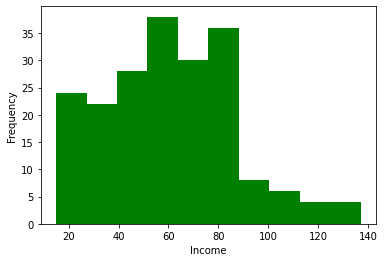

In [6]:
# Plotting a histogram of the Income column

data0.Income.plot.hist(color = 'green')
plt.xlabel('Income')
plt.show()

Beyond 90k, the frequency in the bins falls sharply and it seems that these
customers can naturally be considered a separate group representing 'high-
income customers'. A good proportion of customers seems to lie in the 50k-90k
range. These can be considered 'moderate-income customers'. Customers
earning less than 40k would be 'low-income customers'.

In [7]:
data0['Cluster'] = np.where(data0.Income >= 90, 'High earners',\
                           np.where(data0.Income < 50, \
                                   'Low Income', 'Moderate Income'))

In [8]:
# To check the number of customers in each cluster.
data0.groupby('Cluster')['Income'].describe()

,count,mean,std,min,25%,50%,75%,max
Cluster,,,,,,,,
High earners,22.0,108.181818,13.661334,93.0,98.25,103.0,118.25,137.0
Low Income,72.0,33.027778,11.091136,15.0,22.50,33.5,43.00,49.0
Moderate Income,106.0,69.377358,10.651584,50.0,61.00,70.0,78.00,88.0


### We'll be performing Clustering (Unsupervised Machine Learning) for Customer Segmentation

For our case study, we wish to separate customers based on their income level and spending
scores. Using these, we could have a differential marketing strategy for customers
that have, say, high income and low spending scores versus those with low income
and high spending scores.

In [9]:
# For standardization of data, we will employ the StandardScaler utility in scikit-learn.
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

We are employing StandardScaler to standardize the mall customer data
using z-scoring to ensure that all the variables get similar importance just as the business requires.

In [10]:
cols_to_scale = ['Age', 'Income', 'Spend_score']
data_scaled = data0.copy() # Created a copy of the dataframe to retain orig values and scaling columns on the copied dataset.

In [11]:
data_scaled[cols_to_scale] = scaler.fit_transform(data0[cols_to_scale])

In [12]:
data_scaled[cols_to_scale].describe()

,Age,Income,Spend_score
count,2.000000e+02,2.000000e+02,2.000000e+02
mean,-1.021405e-16,-2.131628e-16,-1.465494e-16
std,1.002509e+00,1.002509e+00,1.002509e+00
min,-1.496335e+00,-1.738999e+00,-1.910021e+00
25%,-7.248436e-01,-7.275093e-01,-5.997931e-01
50%,-2.045351e-01,3.587926e-02,-7.764312e-03
75%,7.284319e-01,6.656748e-01,8.851316e-01
max,2.235532e+00,2.917671e+00,1.894492e+00


The mean value for all the columns is practically 0 and the standard deviation
for all is 1. This ensures that all columns get equal
weightage when calculating the similarity or distance between customers.

### Calculating the Distance between Customers

From the dataset data_scaled created earlier, we'll extract the top three records with the Income and Spend_score fields
into a dataset named cust3

In [13]:
sel_cols = ['Income', 'Spend_score']
cust3 = data_scaled[sel_cols].head(3)
cust3

,Income,Spend_score
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913


In [14]:
# import the cdist method from scipy.spatial.distance tp calculate the distance between them.
from scipy.spatial.distance import cdist

In [15]:
cdist(cust3, cust3, metric = 'euclidean')

array([[0.        , 1.63050555, 1.28167999],
       [1.63050555, 0.        , 2.91186723],
       [1.28167999, 2.91186723, 0.        ]])

The output shows that the distance between the first and the second customer is
1.63 units, while the distance between the first and the third customer is 1.28
units. The distance between the second and the third customer is 2.91 units.

In [16]:
# To verify that 1.6305 is indeed the Euclidean distance between Customer 1 and 2
np.sqrt((-1.739 + 1.739) ** 2 + (-0.4348 - 1.1957) ** 2)

1.6305

### Now we will perform K-means clustering rather than the traditional approach done earlier for customer segmentation to discover natural groups in the mall customers.

In [17]:
cluster_cols = ['Income', 'Spend_score']
data_scaled[cluster_cols].head(3)

,Income,Spend_score
0,-1.738999,-0.434801
1,-1.738999,1.195704
2,-1.700830,-1.715913


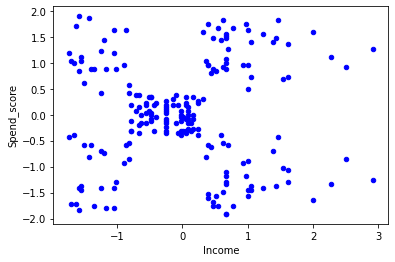

In [18]:
data_scaled.plot.scatter(x = 'Income', y = 'Spend_score', color = 'blue')
plt.show()

From the plot, there are 5 natural clusters in the data. This tells us that we need
to specify 5 as the number of clusters for the k-means algorithm.

In [19]:
from sklearn.cluster import KMeans
model = KMeans(n_clusters = 5, random_state = 42)

In [20]:
#  Specifying a random state ensures that we get the same results on
# repeated executions since the k-means algorithm is not deterministic. 42 is an
# arbitrary choice.

In [21]:
model.fit(data_scaled[cluster_cols])
data_scaled['Cluster'] = model.predict(data_scaled[cluster_cols])
data_scaled.head(3)

,CustomerID,Gender,Age,Income,Spend_score,Cluster
0,1,Male,-1.424569,-1.738999,-0.434801,2
1,2,Male,-1.281035,-1.738999,1.195704,3
2,3,Female,-1.352802,-1.700830,-1.715913,2


#### Now we need to visualize the cluster to see the points assigned to each cluster. We will plot each cluster with a marker.

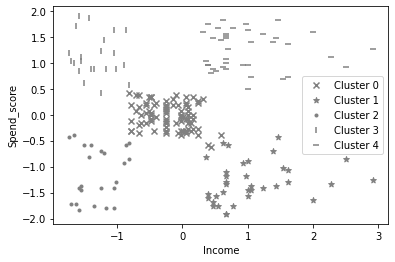

In [22]:
markers = ['x', '*', '.', '|', '_']

for clust in range(5):
    temp = data_scaled[data_scaled.Cluster == clust]
    plt.scatter(temp.Income, temp.Spend_score, \
                marker = markers[clust], \
                color = 'gray', \
                label = "Cluster " + str(clust))
plt.xlabel('Income')
plt.ylabel('Spend_score')
plt.legend()
plt.show()

### Understanding and Describing the Clusters

To understand the characteristics of the clusters better, we will analyze the features
in the original scale and not the standardized features.

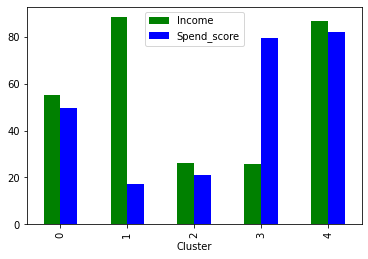

In [23]:
data0['Cluster'] = data_scaled.Cluster
data0.groupby('Cluster')[['Income', 'Spend_score']].mean()\
    .plot.bar(color = ['green', 'blue'])
plt.show()

Each cluster can be described as follows:

* __Cluster 0__: Low-income high spenders
* __Cluster 1__: Moderate-income moderate spenders
* __Cluster 2__: High-income low spenders
* __Cluster 3__: Low-income low spenders
* __Cluster 4__: High-income high spenders

We can also give personas to each segment, that is,
representing each customer segment with an imaginary personality. The
persona has a name and some attributes to help understand its personality.
As an example, Cluster 1 from the previous exercise could be
represented by "Joe." Joe is the quintessential "average customer" whose
income level is right at the average, and so is his spend. He does not spend
beyond his means. Giving a name and personality helps consolidate the
segment understanding into a single, imaginary person, who is much easier
to remember than the values of the segments' attributes.

### Dealing with high-dimensional data
Now we'll perform clustering on the mall customers dataset using
the age, income, and spend score.

In [24]:
cluster_cols = ['Age', 'Income', 'Spend_score']
data_scaled[cluster_cols].head(3)

,Age,Income,Spend_score
0,-1.424569,-1.738999,-0.434801
1,-1.281035,-1.738999,1.195704
2,-1.352802,-1.700830,-1.715913


We'll perform K-means clustering and assign the clusters to a new 'Cluster' column.

In [25]:
model = KMeans(n_clusters = 4, random_state = 42)
model.fit(data_scaled[cluster_cols])

data_scaled['Cluster'] = model.predict(data_scaled[cluster_cols])

#### We'll use Principal Component Analysis (PCA) on the scaled columns and create two new columns pc1 and pc2.

In [26]:
from sklearn import decomposition

pca = decomposition.PCA(n_components = 2)
pca_res = pca.fit_transform(data_scaled[cluster_cols])

data_scaled['pc1'] = pca_res[:,0]
data_scaled['pc2'] = pca_res[:,1]

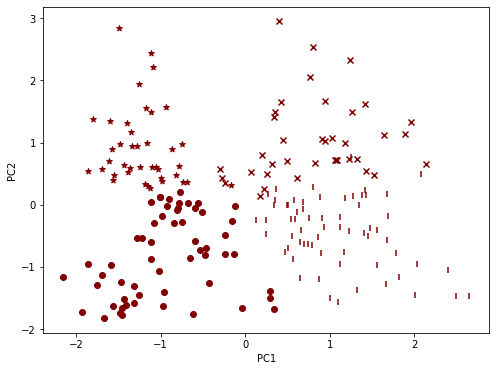

In [27]:
markers = ['x', '*', 'o', '|']

plt.figure(figsize = [8,6])
for clust in range(4):
    temp = data_scaled[data_scaled.Cluster == clust]
    plt.scatter(temp.pc1, temp.pc2, marker = markers[clust], \
               label = "Cluster " + str(clust), \
               color = 'maroon')

    plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

In [28]:
data0['Cluster'] = data_scaled.Cluster
data0.groupby('Cluster')[['Age', 'Income', 'Spend_score']].mean()

,Age,Income,Spend_score
Cluster,,,
0,39.368421,86.500000,19.578947
1,32.875000,86.100000,81.525000
2,25.438596,40.000000,60.298246
3,53.984615,47.707692,39.969231


We see that the spend score varies significantly
between the clusters. This is true for age as well as income.

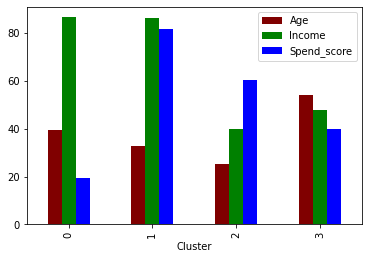

In [29]:
# Visualizing the above information using bar plot.

data0.groupby('Cluster')[['Age', 'Income', 'Spend_score']].mean()\
    .plot.bar(color = ['maroon', 'green','blue'])
plt.show()

We see that all three columns vary significantly across the clusters. We have cluster 0 with the highest average income but lowest spend score and average age. We have cluster 2 which is average in age, high on income and the highest on spending. We can assign descriptive labels to the clusters:

* __Cluster 0__: Middle-aged penny pinchers (high income, low spend)
* __Cluster 1__: Young high rollers (younger age, high income, high spend)
* __Cluster 2__: Young aspirers (low income, high spend)
* __Cluster 3__: Old average Joes (average income, average spend)